In [1]:
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


In [2]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


# 도구 생성

In [3]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool

# 검색 도구 정의(TavilySearch)
tavily_tool = TavilySearch(max_results=5)


# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")

# tmp 폴더가 없으면 생성
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [5]:
from langchain_experimental.tools import PythonREPLTool

# PythonREPL 도구
python_repl_tool = PythonREPLTool()

# 다중 에이전트 생성을 위한 유틸리티 함수 정의

In [6]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory(MODEL_NAME)

In [7]:
# 에이전트 정의
search_agent = create_react_agent(llm, tools=[tavily_tool])
# 에이전트 노드 생성
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

# 에이전트 팀 정의

In [9]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 상태 정의
class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # 메시지
    team_members: List[str]  # 멤버 에이전트 목록
    next: str  # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 검색 노드 생성
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

# 웹 스크래핑 노드 생성
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Supervisor 에이전트 생성
supervisor_agent = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

In [10]:
def get_next_node(x):
    return x["next"]

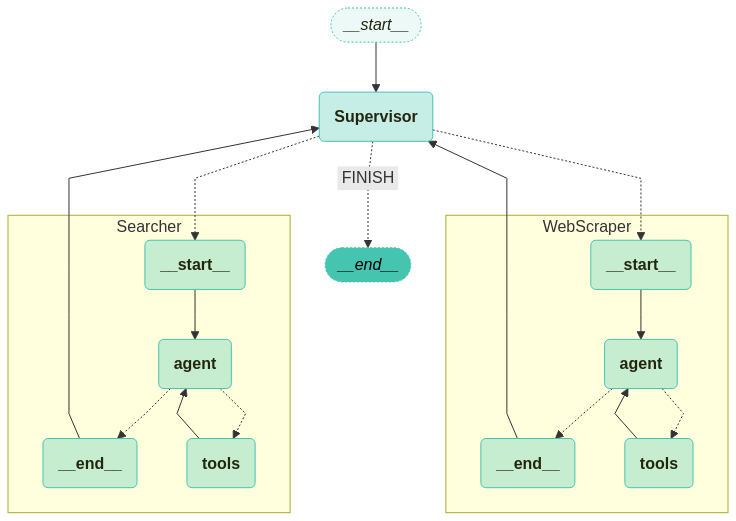

In [11]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("Supervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)

In [12]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 50):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [13]:
output = run_graph(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_kxd04NuadRsJOPJTvgkZjdvs)
 Call ID: call_kxd04NuadRsJOPJTvgkZjdvs
  Args:
    urls: ['https://finance.naver.com/news']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="네이버페이 증권">



네이버페이 증권


































메인 메뉴로 바로가기
본문으로 바로가기










네이버





페이






증권






증권 종목명·지수명 검색







검색


자동완성







@code@
@txt@
@market@

@full_txt@
@in_code@
@in_name@
@in_link@
@in_market@




												공모주와 해외 종목은 모바일 페이지로 이동합니다.
											








												현재 자동완성 기능을 사용하고 계십니다.
											









												자동완성 기능이 활성화되었습니다.
					

In [14]:
# 최종 결과 출력
print(output["messages"][-1].content)

Here are some of the major news headlines from the Naver Finance news page:

1. **코스피, 돌아온 외인에 2540선 회복…환율 상승 전환**  
   Source: 더팩트

2. **깜짝실적에 美 러브콜까지…순풍에 돛 단 조선株[살까팔까]**  
   Source: 연합뉴스

3. **HD현대건설기계 "5년 내 매출 6조"…연기금도 베팅 [마켓딥다이브]**  
   Source: 한국경제TV

4. **美 '반도체3배' 몰리고 '바이오·코인' 급등 [주간ETF동향]**  
   Source: 한국경제TV

5. **"미중 관세 협상, 베트남·EU 태도에 달려"**  
   Source: 한국경제TV

6. **미·중 갈등에 해운주 들썩… 반사이익 vs 업황 침체[체크!코스닥]**  
   Source: 머니S

For more details, you can visit the [Naver Finance News page](https://finance.naver.com/news).


In [15]:
import operator
from typing import List, TypedDict, Annotated
from pathlib import Path


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)  # tmp 폴더가 없으면 생성


# 상태 정의
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str  # 현재 작업중인 파일


# 상태 전처리 노드: 각각의 에이전트가 현재 작업 디렉토리의 상태를 더 잘 인식할 수 있도록 함
def preprocess(state):
    # 작성된 파일 목록 초기화
    written_files = []

    try:
        # 작업 디렉토리 내의 모든 파일을 검색하여 상대 경로로 변환
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    # 작성된 파일이 없으면 상태에 "No files written." 추가
    if not written_files:
        return {**state, "current_files": "No files written."}

    # 작성된 파일 목록을 상태에 추가
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME)

# 문서 작성 에이전트 생성
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier="You are a arxiv researcher. Your mission is to write arxiv style paper on given topic/resources.",
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

# 노트 작성 노드
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier="You are an expert in creating outlines for research papers. Your mission is to create an outline for a given topic/resources or documents.",
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)


# 차트 생성 에이전트 생성
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

# 문서 작성 팀 감독자 생성
doc_writing_supervisor = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [16]:
# 그래프 생성
authoring_graph = StateGraph(DocWritingState)

# 노드 정의
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# 엣지 정의
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# 시작 노드 설정
authoring_graph.set_entry_point("Supervisor")

# 그래프 컴파일
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

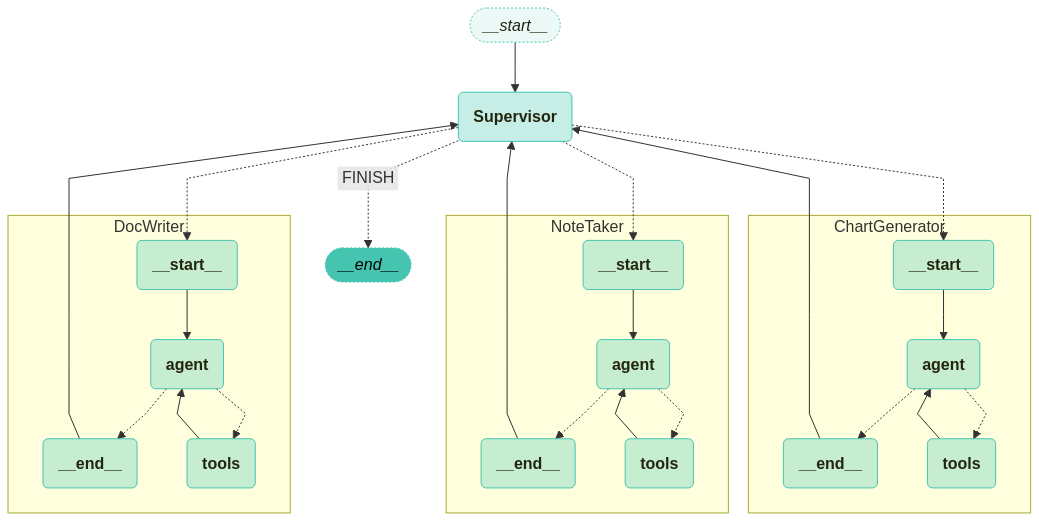

In [17]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(authoring_app, xray=True)

In [18]:
output = run_graph(
    authoring_app,
    "Transformer 의 구조에 대해서 심층 파악해서 논문의 목차를 한글로 작성해줘. "
    "그 다음 각각의 목차에 대해서 5문장 이상 작성해줘. "
    "상세내용 작성시 만약 chart 가 필요하면 차트를 작성해줘. "
    "최종 결과를 저장해줘. ",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
DocWriter

🔄 Node: agent in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_document (call_fOYwvYdZkRFPIhjIFCs4PnQo)
 Call ID: call_fOYwvYdZkRFPIhjIFCs4PnQo
  Args:
    content: 제목: 트랜스포머 모델의 심층 분석

목차:
1. 서론
2. 트랜스포머의 기본 구조
3. 셀프 어텐션 메커니즘
4. 포지셔널 인코딩
5. 인코더와 디코더
6. 어텐션 헤드와 멀티 헤드 어텐션
7. 피드 포워드 네트워크
8. 트랜스포머의 장점
9. 응용 분야
10. 결론

각 목차에 대한 상세내용:

1. 서론
이 장에서는 자연어 처리 분야에서 혁신적인 변화를 가져온 트랜스포머 모델의 중요성을 강조하고자 합니다. 트랜스포머는 순환 신경망(RNN)과는 다른 혁신적인 방법으로 정보를 처리하여 더 나은 성능을 보여줍니다. 본 논문은 트랜스포머의 구조를 심층적으로 분석하여 그 작동 원리를 명확히 이해하려는 목표를 가지고 있습니다. 이를 통해 트랜스포머가 어떻게 다양한 자연어 처리 작업에서 우수한 성능을 발휘하는지 설명할 것입니다. 트랜스포머의 등장 배경과 중요성을 간략히 소개하겠습니다.

2. 트랜스포머의 기본 구조
트랜스포머 모델은 크게 인코더와 디코더로 구성됩니다. 인코더는 입력 문장을 처리하여 문맥 정보가 포함된 벡터로 변환하고, 디코더는 이러한 벡터를 활용하여 출력 문장을 생성합니다. 인코더와 디코더는 각각 여러 개의 층(layer)으로 구성되어 있으며, 각 층은 셀프 어텐션과 피드 포워드 네트워크로 구

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_fPGjdF5nj9F6UAHXvUGGpvTz)
 Call ID: call_fPGjdF5nj9F6UAHXvUGGpvTz
  Args:
    query: with open('transformer_analysis_detailed_kor.txt', 'w') as file:
    content = '''### 목차:
1. 서론
2. 트랜스포머의 기본 구조
3. 셀프 어텐션 메커니즘
4. 포지셔널 인코딩
5. 인코더와 디코더
6. 어텐션 헤드와 멀티 헤드 어텐션
7. 피드 포워드 네트워크
8. 트랜스포머의 장점
9. 응용 분야
10. 결론

---

각각의 목차에 대한 상세 설명:
1. **서론**
   - 이 장에서는 자연어 처리 분야에서 혁신적인 변화를 가져온 트랜스포머 모델의 중요성을 강조하고자 합니다. 트랜스포머는 순환 신경망(RNN)과는 다른 혁신적인 방법으로 정보를 처리하여 더 나은 성능을 보여줍니다. 본 논문은 트랜스포머의 구조를 심층적으로 분석하여 그 작동 원리를 명확히 이해하려는 목표를 가지고 있습니다. 이를 통해 트랜스포머가 어떻게 다양한 자연어 처리 작업에서 우수한 성능을 발휘하는지 설명할 것입니다. 트랜스포머의 등장 배경과 중요성을 간략히 소개하겠습니다.

2. **트랜스포머의 기본 구조**
   - 트랜스포머 모델은 크게 인코더와 디코더로 구성됩니다. 인코더는 입력 문장을 처리하여 문맥 정보가 포함된 벡터로 변환하고, 디코더는 이러한 벡터를 활용하여 출력 문장을 생성합니다. 인코더와 디코더는 각각 여러 개의 층(layer)으로 구성되어 있으며, 각 층은 셀프 어텐션과 피드 포워드 네트워크로 

# Super-Graph 생성

In [19]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

# 기본 LLM으로 ChatOpenAI 인스턴스 생성
llm = ChatOpenAI(model=MODEL_NAME)

# 팀 감독자 노드 생성
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['ResearchTeam', 'PaperWritingTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [20]:
from typing import TypedDict, List, Annotated
import operator


# 상태 정의
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # 라우팅 결정
    next: str


# 마지막 메시지 반환 노드
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# 응답 종합 노드
def join_graph(response: dict):
    # 마지막 메시지를 추출하여 메시지 목록으로 반환
    return {"messages": [response["messages"][-1]]}

In [21]:
# 그래프 정의
super_graph = StateGraph(State)

# 노드 정의
super_graph.add_node("ResearchTeam", get_last_message | web_research_app | join_graph)
super_graph.add_node("PaperWritingTeam", get_last_message | authoring_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# 엣지 정의
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PaperWritingTeam", "Supervisor")

# 조건부 엣지 추가: Supervisor 의 결정에 따라 다음 노드로 이동
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)

# Supervisor 노드를 시작 노드로 설정
super_graph.set_entry_point("Supervisor")

# 그래프 컴파일
super_graph = super_graph.compile(checkpointer=MemorySaver())

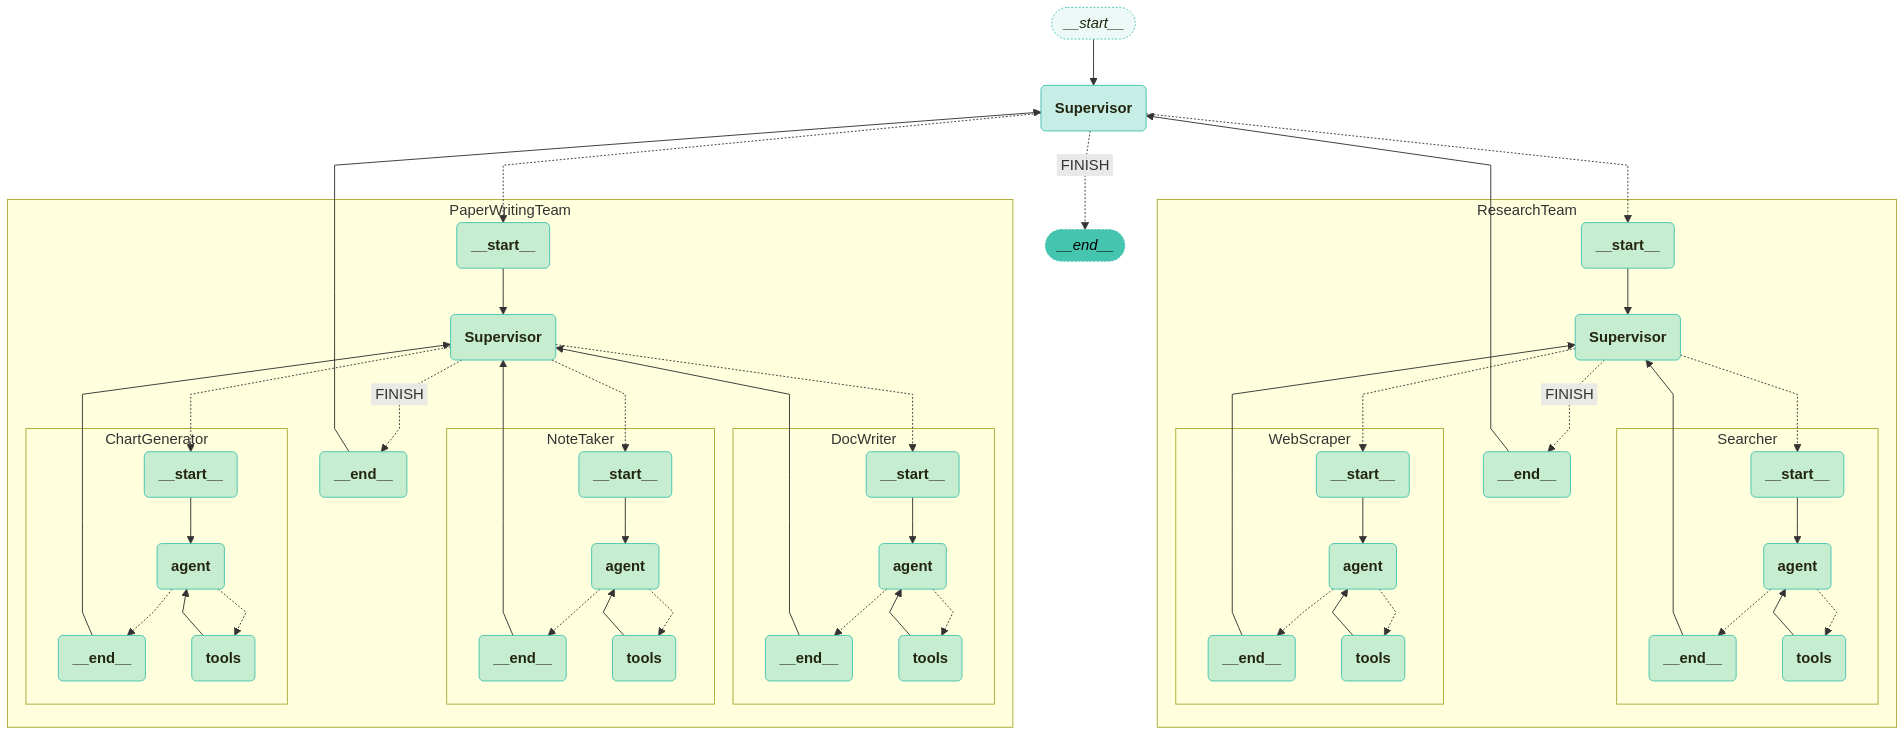

In [22]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(super_graph, xray=True)

In [23]:
output = run_graph(
    super_graph,
    """주제: multi-agent 구조를 사용하여 복잡한 작업을 수행하는 방법

상세 가이드라인:
- 주제에 대한 Arxiv 논문 형식의 리포트 생성
- Outline 생성
- 각각의 Outline 에 대해서 5문장 이상 작성
- 상세내용 작성시 만약 chart 가 필요하면 차트 생성 및 추가
- 한글로 리포트 작성
- 출처는 APA 형식으로 작성
- 최종 결과는 .md 파일로 저장""",
    recursive_limit=150,
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
ResearchTeam

🔄 Node: Supervisor in [ResearchTeam] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Searcher

🔄 Node: agent in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

## Arxiv 논문 형식의 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

### Outline

1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 시 고려사항
6. 결론

---

### 1. 서론

Multi-Agent 시스템은 여러 개의 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성하는 데 기여합니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 시 고려해야 할 요소들을 제시합니다.

### 2. Multi-Agent 시스템의 개요

Multi-Agent 시스템은 여러 개의 자율적인 에이전트로 구성되며, 각 에이전트는 독립적으로 의사결정을 내릴 수 있는 능력을 갖추고 있습니다. 이러한

In [24]:
from IPython.display import Markdown

if hasattr(output["messages"][-1], "content"):
    display(Markdown(output["messages"][-1].content))
else:
    display(Markdown(output["messages"][-1]))

위의 내용을 바탕으로 .md 파일을 생성하였습니다. 아래는 해당 파일의 내용입니다:

```markdown
# Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

## 1. 서론

Multi-Agent 시스템은 여러 개의 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성하는 데 기여합니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 시 고려해야 할 요소들을 제시합니다.

## 2. Multi-Agent 시스템의 개요

Multi-Agent 시스템은 여러 개의 자율적인 에이전트로 구성되며, 각 에이전트는 독립적으로 의사결정을 내릴 수 있는 능력을 갖추고 있습니다. 이러한 시스템은 분산된 문제 해결 방식을 채택하여 복잡한 문제를 효율적으로 해결할 수 있습니다. 에이전트들은 서로 다른 역할과 책임을 가지며, 협력과 경쟁을 통해 목표를 달성합니다. Multi-Agent 시스템은 주로 분산 컴퓨팅, 로봇공학, 네트워크 관리 등 다양한 분야에서 활용됩니다. 이러한 시스템의 핵심은 에이전트 간의 효과적인 통신과 협력입니다.

## 3. Multi-Agent 구조의 장점

Multi-Agent 구조는 여러 가지 장점을 제공합니다. 첫째, 시스템의 유연성과 확장성이 뛰어납니다. 새로운 에이전트를 추가하거나 기존 에이전트를 제거하는 것이 용이하여 시스템의 확장이 가능합니다. 둘째, 복잡한 문제를 분할하여 해결할 수 있어 문제 해결의 효율성을 높입니다. 셋째, 에이전트 간의 협력을 통해 시스템의 신뢰성과 안정성을 향상시킬 수 있습니다. 넷째, 분산된 구조로 인해 단일 실패 지점(single point of failure)이 줄어들어 시스템의 견고성이 증가합니다. 마지막으로, 다양한 분야에 적용 가능하여 범용성이 높습니다.

## 4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례

Multi-Agent 시스템은 다양한 분야에서 복잡한 작업을 수행하는 데 활용됩니다. 예를 들어, 물류 및 공급망 관리에서는 여러 로봇이 협력하여 물품을 효율적으로 이동시키는 데 사용됩니다. 또한, 금융 분야에서는 에이전트들이 시장 데이터를 분석하고 거래 전략을 수립하는 데 기여합니다. 스마트 그리드에서는 에너지 자원을 효율적으로 관리하기 위해 Multi-Agent 시스템이 활용됩니다. 이러한 사례들은 Multi-Agent 시스템이 복잡한 작업을 효과적으로 수행할 수 있음을 보여줍니다. 각 사례는 에이전트 간의 협력과 통신이 핵심적인 역할을 합니다.

## 5. Multi-Agent 시스템 설계 시 고려사항

Multi-Agent 시스템을 설계할 때는 여러 가지 요소를 고려해야 합니다. 첫째, 에이전트 간의 통신 프로토콜을 명확히 정의해야 합니다. 둘째, 에이전트의 자율성과 협력 수준을 조정하여 시스템의 목표를 효과적으로 달성할 수 있도록 해야 합니다. 셋째, 시스템의 확장성과 유연성을 고려하여 설계해야 합니다. 넷째, 에이전트의 학습 능력을 강화하여 변화하는 환경에 적응할 수 있도록 해야 합니다. 마지막으로, 시스템의 보안과 프라이버시를 고려하여 설계해야 합니다.

## 6. 결론

Multi-Agent 시스템은 복잡한 작업을 효율적으로 수행할 수 있는 강력한 도구입니다. 이러한 시스템은 다양한 분야에서 활용되며, 에이전트 간의 협력과 통신을 통해 문제를 해결합니다. 본 논문에서는 Multi-Agent 구조의 개요와 장점, 적용 사례, 설계 시 고려사항을 제시하였습니다. 앞으로도 Multi-Agent 시스템은 더욱 발전하여 다양한 분야에서 중요한 역할을 할 것으로 기대됩니다.

## 출처

- Wooldridge, M. (2009). An Introduction to MultiAgent Systems. John Wiley & Sons.
- Jennings, N. R., & Wooldridge, M. (1998). Applications of intelligent agents. In Agent technology (pp. 3-28). Springer, Berlin, Heidelberg.
- Russell, S., & Norvig, P. (2016). Artificial Intelligence: A Modern Approach. Pearson.
```

이 파일을 저장하여 사용하시면 됩니다.